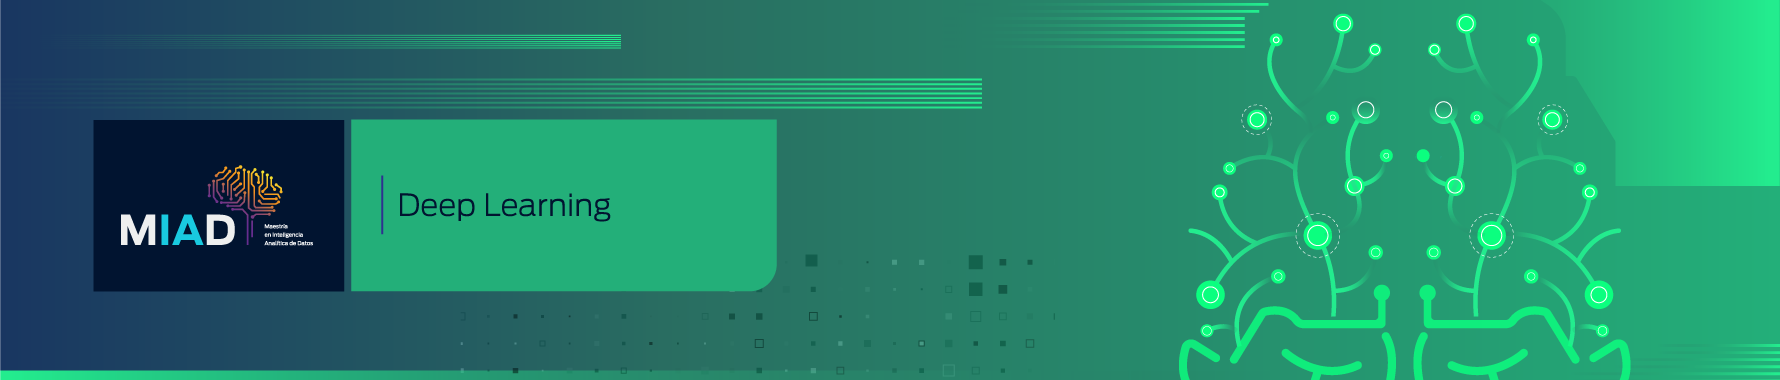

# Deep learning - Semana 3: Estrategias de implementación
# Gradiente Descendiente con Momento _(Momentum)_ 

## Propósito
En esta actividad se implementan y comparan las diferentes estrategias de momento para mejorar y agilizar el algoritmo de gradiente descendiente. 

## Instrucciones generales

Esta es una actividad individual, la cual puede descargar eligiendo la opción ‘Download as’ del menú ‘File’ y descargar el archivo en formato notebook (.ipynb). También puede resolverla directamente sobre la herramienta del curso.

En el laboratorio hay dos ejercicios: 
1. Implementación manual de estrategia de momento en estimación de red neuronal de una capa.
2. Implementación de momento en _Keras_ y comparación de valores de hiperparámetros.


## 1. Implementación manual de momento en estimación de red neuronal de una capa

En este caso se trabajará con la implementación "manual" del algoritmo de gradiente descendiente para una red neuronal de una capa que desarrollamos en un laboratorio anterior. 

Los datos a usar fueron extraídos de imágenes que fueron tomadas de billetes. Para su digitalización, se utilizó una cámara industrial usada para la impresión. Luego, las imágenes de 400x400 pixeles se sometieron a un procedimiento de transformación de onda (Wavelet transformation) con la intención de extraer las _features_ (características) para la predicción. En este contexto, la variable de respuesta corresponde a si un billete es auténtico ($y=1$) o si no lo es ($y=0$) y las variables predictivas son las siguientes:

1. *Variance* *of* *Wavelet* *Transformed* *image* *(continuous)*
2. *Skewness* *of* *Wavelet* *Transformed* *image* *(continuous)*
3. *Curtosis* *of* *Wavelet* *Transformed* *image* *(continuous)*
4. *Entropy* *of* *image* *(continuous)*

Primero, ejecutemos las funciones para definir las estructuras, inicialización de parámetros, la función de activación y el mecanismo de _forward propagation_ :


In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt

data = np.genfromtxt('data_banknote_authentication.txt', delimiter = ',')
X = data[:,:4]
y = data[:, 4]
y=y.reshape(y.shape[0], 1)

def estructuras(X, Y):
    input_unit = X.shape[1] # Dimensión de entrada
    hidden_unit = 58 # Unidades de capa oculta
    output_unit = Y.shape[1] # Dimensión de variable de salida
    return (input_unit, hidden_unit, output_unit)


def inicializacion(input_unit, hidden_unit, output_unit):
    np.random.seed(3) 
    W1 = np.random.randn(input_unit, hidden_unit)*0.01
    b1 = np.zeros((1, hidden_unit))
    W2 = np.random.randn(hidden_unit, output_unit)*0.01
    b2 = np.zeros((1, output_unit))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters


def sigmoid(z):
    return 1/(1+np.exp(-z))

def forward_propagation(X, parameters):
    
    #Se cargan los valores de los parámetros
    
    W1 = parameters['W1'] #Valor de los pesos de la primera capa
    b1 = parameters['b1'] #Valor de los interceptos de la primera capa
    W2 = parameters['W2'] #Valor de los pesos de la salida
    b2 = parameters['b2'] #Valor de los interceptos de la salida
    
    Z1 = np.dot(X, W1) + b1 #Cálculo de la transformación afín de la primera capa
    A1 = sigmoid(Z1) #Evaluación de la función sigmoide de la primera capa
    Z2 = np.dot(A1, W2) + b2 #Cálculo de la transformación afín de la salida
    A2 = sigmoid(Z2) #Evaluación de la función sigmoide de la salida
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    
    return A2, cache

Ahora definimos la función objetivo a inimizar _(cross-entropy)_ y el cálculo de gradientes por _backward propagation_.


In [2]:
def cross_entropy_cost(A2, Y, parameters):
    # Muestras de entrenamiento
    n = Y.shape[0] 
    # Calcular cross entropy
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / n
    cost = float(np.squeeze(cost))    
    
    return cost


def backward_propagation(parameters, cache, X, Y):
    #Muestras de entrenamiento
    n = X.shape[0]
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    dZ2 = (1/n) *(A2-Y)
    dW2 = np.dot(A1.T,dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dZ1 = np.multiply(np.dot(dZ2,W2.T), A1 - np.power(A1, 2))
    dW1 = np.dot(X.T,dZ1) 
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2,"db2": db2}
    return grads

### Implementación _Gradient Descent_ con momento:
En la función de "gradient descent" se implementa la estrategia de momento usando el valor de $s(\theta)$ como la función suavizada de los gradientes $d(\theta)$ para el parámetro $\theta$ que puede representar una matriz $W$ o un vector de interceptos $b$. En la función "neural network model" se actualizan los valores de $s(\theta)$.

El parámetro del momento $\beta_M$ se deja como un hiperparámetro para el cual se puede poner un valor en el intervalo $[0,1]$.

In [3]:
#Definición parámetro de suavización momento
#beta_m = 0.9

def gradient_descent(parameters, smooth, learning_rate = 0.01):
    
    #Se capturan los valores actuales para los parámetros de la red neuronal
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #Se capturan los valores de los gradientes suavizados
    sW1 = smooth['sW1']
    sb1 = smooth['sb1']
    sW2 = smooth['sW2']
    sb2 = smooth['sb2']
    
    #Se actualizan los valores de los parámetros siguiendo la dirección contraria del gradiente
    W1 = W1 - learning_rate * sW1
    b1 = b1 - learning_rate * sb1
    W2 = W2 - learning_rate * sW2
    b2 = b2 - learning_rate * sb2
    
    parameters = {"W1": W1, "b1": b1,"W2": W2,"b2": b2}
    
    return parameters


def neural_network_model(X, Y, hidden_unit, beta_m=0.9, num_iterations = 10000):
    np.random.seed(3)
        
    input_unit = estructuras(X, Y)[0]
    output_unit = estructuras(X, Y)[2]
    
    #Se inicializan los parámetros de manera aleatoria
    parameters = inicializacion(input_unit, hidden_unit, output_unit)
   
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    costs=[]
    
    #inicializadión de términos suavización exponencial
    sW1 = 0
    sb1 = 0
    sW2 = 0
    sb2 = 0
    
    for i in range(0, num_iterations):
                
        A2, cache = forward_propagation(X, parameters) #Se calcula la salida de la red para los datos utilizados y los valores de los parámetros para cada iteración
        
        cost = cross_entropy_cost(A2, Y, parameters) #Se calcula la función de costos
        
        costs.append(cost) #Se guardan el valor de la función de costos para cada iteración
        
        grads = backward_propagation(parameters, cache, X, Y) #Se calcula el gradiente de la función de costos utilizando el método de backpropagation para cada iteración
    
        dW1 = grads['dW1']
        db1 = grads['db1']
        dW2 = grads['dW2']
        db2 = grads['db2']
        
        sW1 = sW1*beta_m + (1-beta_m)*dW1
        sb1 = sb1*beta_m + (1-beta_m)*db1
        sW2 = sW2*beta_m + (1-beta_m)*dW2
        sb2 = sb2*beta_m + (1-beta_m)*db2
        
        smooth={"sW1": sW1, "sb1": sb1, "sW2": sW2,"sb2": sb2}
        
        parameters = gradient_descent(parameters, smooth,learning_rate=0.15) #Se actualiza el valor de los parámetros de acuerdo al gradiente calculado en cada iteración
        if i % 5 == 0:
            print ("Costo en la iteracion  %i: %f" %(i, cost))
    return parameters, costs

Ahora comparamos el avance del algoritmo usando diferentes valores para el parámetro $\beta_M$ que define la memoria de la suavización exponencial por momentos. Para ambos casos se usan 20 unidades en la capa oculta y una tasa de aprendizaje de 0.15.

Empezamos con el algortimo normal, en el cual no se usa la estrategia de momento (este proceso puede tomar unos minutos si se ejecuta en la plataforma de Coursera):

In [4]:
start = time.time()
parameters, costs = neural_network_model(X, y, 20, beta_m=0, num_iterations=15000)
end = time.time()
print("Tiempo de ejecución: " +str(end - start))

Costo en la iteracion  0: 0.691762
Costo en la iteracion  5: 0.686732
Costo en la iteracion  10: 0.684795
Costo en la iteracion  15: 0.682508
Costo en la iteracion  20: 0.679274
Costo en la iteracion  25: 0.674589
Costo en la iteracion  30: 0.667870
Costo en la iteracion  35: 0.658487
Costo en la iteracion  40: 0.645861
Costo en la iteracion  45: 0.629606
Costo en la iteracion  50: 0.609658
Costo en la iteracion  55: 0.586251
Costo en la iteracion  60: 0.559732
Costo en la iteracion  65: 0.530414
Costo en la iteracion  70: 0.498668
Costo en la iteracion  75: 0.465123
Costo en la iteracion  80: 0.430750
Costo en la iteracion  85: 0.396708
Costo en la iteracion  90: 0.364074
Costo en la iteracion  95: 0.333641
Costo en la iteracion  100: 0.305852
Costo en la iteracion  105: 0.280855
Costo en la iteracion  110: 0.258588
Costo en la iteracion  115: 0.238866
Costo en la iteracion  120: 0.221446
Costo en la iteracion  125: 0.206064
Costo en la iteracion  130: 0.192467
Costo en la iteracion  

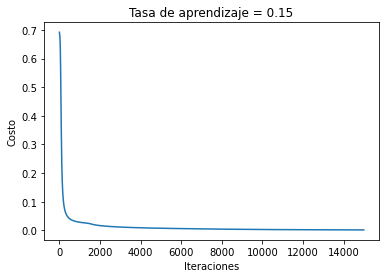

In [5]:
plt.plot(costs)
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
plt.title("Tasa de aprendizaje = 0.15" )
plt.show()

Ahora miremos el avance del algoritmo usando $\beta_M=0.9$ (este proceso puede tomar unos minutos si se ejecuta en la plataforma de Coursera):

In [6]:
start = time.time()
parameters, costs = neural_network_model(X, y, 20, beta_m=0.9, num_iterations=15000)
end = time.time()
print("Tiempo de ejecución: " +str(end - start))

Costo en la iteracion  0: 0.691762
Costo en la iteracion  5: 0.689461
Costo en la iteracion  10: 0.686906
Costo en la iteracion  15: 0.685774
Costo en la iteracion  20: 0.684688
Costo en la iteracion  25: 0.682789
Costo en la iteracion  30: 0.680267
Costo en la iteracion  35: 0.677200
Costo en la iteracion  40: 0.673243
Costo en la iteracion  45: 0.668014
Costo en la iteracion  50: 0.661257
Costo en la iteracion  55: 0.652732
Costo en la iteracion  60: 0.642155
Costo en la iteracion  65: 0.629272
Costo en la iteracion  70: 0.613917
Costo en la iteracion  75: 0.596044
Costo en la iteracion  80: 0.575707
Costo en la iteracion  85: 0.553007
Costo en la iteracion  90: 0.528030
Costo en la iteracion  95: 0.500854
Costo en la iteracion  100: 0.471643
Costo en la iteracion  105: 0.440809
Costo en la iteracion  110: 0.409084
Costo en la iteracion  115: 0.377441
Costo en la iteracion  120: 0.346866
Costo en la iteracion  125: 0.318120
Costo en la iteracion  130: 0.291641
Costo en la iteracion  

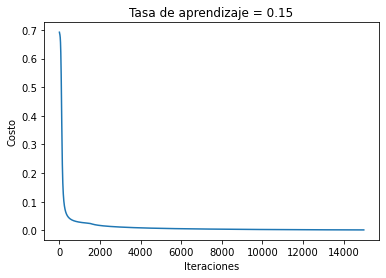

In [7]:
plt.plot(costs)
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
plt.title("Tasa de aprendizaje = 0.15" )
plt.show()

Es impotante notar que la ventaja de la estrategia del momento, es mucho más notoria cuando la función de pérdidad $L(\theta)$ es más complicada, es decir, existen muchos más parámetros (posiblemente muchas capas) y un número de observaciones muy alto.

En este caso, se presenta un ejercicio ilustrativo, en donde se fijan el número de iteraciones. Sin embargo, en aplicaciones reales, es importante calibrar la tasa de aprendizaje $\alpha$ dependiente del valor del parámetro $\beta_M$.


#### Ejercicio no evaluable:
Intente calibrar los parámetros $\alpha$ y $\beta_M$ en ambos modelos para determinar qué tanta ventaja en términos de velocidad de descenso tiene la estrategia de momento.


## 2. Implementación de momento en Keras y comparación de valores de hiperparámetros

En _Keras_ , el parámetro usado para controlar el tamaño de lote es: "momentum", el cual es parametrizable para el optimizador "SGD", que corresponde a la implementación genérica de _mini-batch_ con tamaños de lote desde $n_{train}$ (_batch gradient descent_) hasta 1, que es la versión completamente estocástica.

En este caso, uasaremos la base de datos del _National Institute of Diabetes and Digestive and Kidney Diseases_. La variable de interés 'Clase' es una variable binaria que toma el valor de 1 en caso de que el paciente tenga diabetes o de 0 en caso contrario. Estos datos ya habían sido usados en un ejercicio anterior y en este caso, exploraremos la sensibilidad de la estimación de la red en términos del _momentum_.

In [8]:
import pandas as pd
from numpy import loadtxt
from matplotlib import pyplot  as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics

from keras.optimizers import SGD  #para cambiar el parámetro "momentum"

dataset = pd.read_csv('test2.csv', sep=",")
dataset=dataset.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(dataset[:,0:8], dataset[:,8], test_size=0.20)

Using TensorFlow backend.



Recuerde que la tasa de aprendizaje $(\alpha)$ que funciona para un valor de momentum, no es necesariamente igual a la que funciona para otro valor. En el siguiente código, puede experiemtar sobre la major combinación entre estos dos parámetros.

In [9]:
n=X_train.shape[0]

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

momentum=0.5

sgd=SGD(learning_rate=0.005, momentum=momentum)

model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

start = time.time()

#history=model.fit(X_train, y_train, epochs=250, batch_size=128)

history=model.fit(X_train, y_train, epochs=250, batch_size=32)

end = time.time()

Epoch 1/250
614/614 [==============================] - 0s 282us/step - loss: 3.3409 - accuracy: 0.6042
Epoch 2/250
614/614 [==============================] - 0s 34us/step - loss: 0.6757 - accuracy: 0.6482
Epoch 3/250
614/614 [==============================] - 0s 33us/step - loss: 0.6675 - accuracy: 0.6515
Epoch 4/250
614/614 [==============================] - 0s 32us/step - loss: 0.6483 - accuracy: 0.6498
Epoch 5/250
614/614 [==============================] - 0s 25us/step - loss: 0.6357 - accuracy: 0.6498
Epoch 6/250
614/614 [==============================] - 0s 27us/step - loss: 0.6311 - accuracy: 0.6515
Epoch 7/250
614/614 [==============================] - 0s 30us/step - loss: 0.6246 - accuracy: 0.6531
Epoch 8/250
614/614 [==============================] - 0s 31us/step - loss: 0.6193 - accuracy: 0.6531
Epoch 9/250
614/614 [==============================] - 0s 27us/step - loss: 0.6282 - accuracy: 0.6531
Epoch 10/250
614/614 [==============================] - 0s 27us/step - loss: 0.61

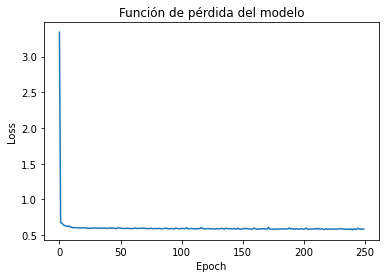

Tiempo de ejecución: 4.458057880401611


In [10]:
plt.plot(history.history['loss'])
plt.title('Función de pérdida del modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

print("Tiempo de ejecución: " +str(end - start))